In [1]:
%matplotlib inline
import h5py
import numpy as np
from os import path
from IPython.core.display import Image, display
from skimage.draw import polygon_perimeter
from skimage.io import imread
import skimage.transform
import skimage
import matplotlib.pyplot as plt
import pickle
import pandas as pd

Reading SVHN data...

In [2]:
base_path = 'data/train/'
data_file_path = path.join(base_path, 'digits_data.pickle')
data = None

if path.exists(data_file_path):
    print('Loading data from Pickle')
    with open(data_file_path, 'rb') as file:
        data = pickle.load(file)
else:
    # some help from
    # https://stackoverflow.com/questions/33509163/how-to-read-mat-v7-3-files-in-python
    def get_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(int(obj[0][0]))
        else:
            for k in range(obj.shape[0]):
                vals.append(int(data_file[obj[k][0]][0][0]))
        data[name].append(vals)
    
    print('Reading data from .mat file')
    matlab_data_file_path = path.join(base_path, 'digitStruct.mat')
    data_file = h5py.File(matlab_data_file_path)
    
    data = {}
    data['paths'] = []
    data['label'] = []
    data['height'] = []
    data['left'] = []
    data['top'] = []
    data['width'] = []
    
    print('Reading images names...')
    column = data_file['digitStruct']['name']
    for item in column:
        image_name = map(chr, data_file[item[0]][:])
        image_path = path.join(base_path, ''.join(image_name))
        data['paths'].append(image_path)
        
    print('Reading images bounding boxes and labels...')
    column = data_file['digitStruct']['bbox']
    for item in column:
        data_file[item[0]].visititems(get_attrs)
        
    print('Dumping Pickle file')
    with open(data_file_path, 'wb') as file:
        pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)

print('DONE')

Loading data from Pickle
DONE


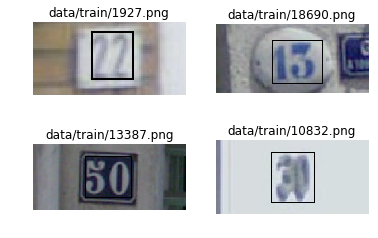

In [3]:
def plot_bounding_box(data, index, ax):
    img = imread(data['paths'][index])
    left = np.min(data['left'][index])
    top = np.min(data['top'][index])
    bottoms = [sum(x) for x in zip(data['top'][index], data['height'][index])]
    bottom = np.max(bottoms)
    right = left + np.sum(data['width'][index])
    (rr, cc) = polygon_perimeter((top, bottom, bottom, top),
                                 (left, left, right, right),
                                 shape=img.shape)
    img[rr, cc] = 0
    ax.axis('off')
    ax.set_title(data['paths'][index])
    ax.imshow(img)


n_rows = 2
n_cols = 2
(fig, axes) = plt.subplots(nrows=n_rows, ncols=n_cols)

indexes = np.arange(len(data['paths']))
np.random.shuffle(indexes)

for i in range(n_rows):
    for j in range(n_cols):
        index = i * n_rows + j
        plot_bounding_box(data, indexes[index], axes[i, j])

In [4]:
# let's look at some images with "wrong" bounding boxes
# some examples: data/train/30500.png, data/train/27212.png, data/train/32074.png
index = data['paths'].index('data/train/30500.png')
print(data['left'][index])
print(data['top'][index])
print(data['height'][index])
print(data['width'][index])
print(data['label'][index])

[113]
[23]
[61]
[31]
[8]


[2 3 1 4 5 6]


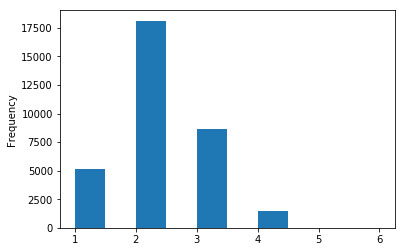

In [5]:
# looking at how much numbers there is in each image
numbers_per_image = map(len, data['label'])
s = pd.Series(numbers_per_image)
s.plot(kind='hist')
print(s.unique())

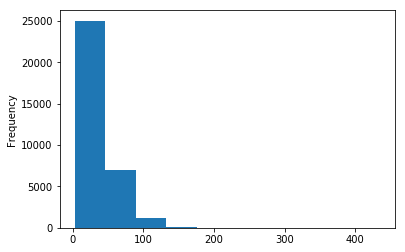

In [6]:
# looking at the width of the bounding boxes
bounding_box_width = map(sum, data['width'])
s = pd.Series(bounding_box_width)
s.plot(kind='hist')

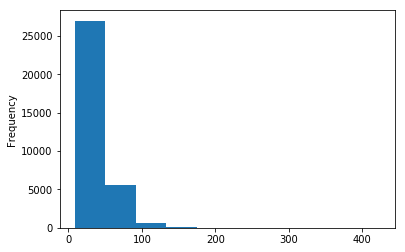

In [7]:
# looking at the height of the bounding boxes
tops = map(min, data['top'])
bottoms = map(max,
              map(lambda tb: map(sum, zip(tb[0], tb[1])),
                  zip(data['top'], data['height'])))
bounding_box_height = map(lambda tb: tb[1] - tb[0], zip(tops, bottoms))
s = pd.Series(bounding_box_height)
s.plot(kind='hist')

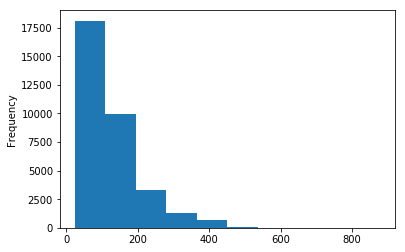

In [8]:
widths = map(lambda i: i.shape[1],
             map(imread, data['paths']))
s = pd.Series(widths)
s.plot(kind='hist')

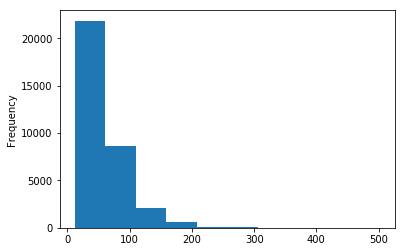

In [9]:
heights = map(lambda i: i.shape[0],
             map(imread, data['paths']))
s = pd.Series(heights)
s.plot(kind='hist')

Mean: 2.274065183863909
Std. dev.: 0.36038915872704336
If we set the image height to 43
The width will be 100


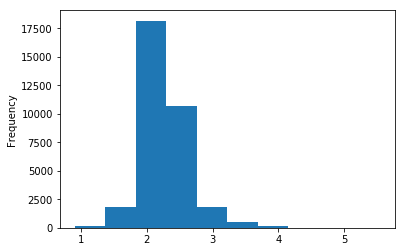

In [10]:
aspect_ratios = map(lambda i: float(i.shape[1]) / i.shape[0],
             map(imread, data['paths']))
s = pd.Series(aspect_ratios)
s.plot(kind='hist')
print('Mean: {}'.format(s.mean()))
print('Std. dev.: {}'.format(s.std()))

width = 100
height = int(width / s.mean())
print('If we set the image height to {}'.format(height))
print('The width will be {}'.format(width))

In [70]:
def pad_image(image, shape):
    offset_left = np.max([int(float(shape[1] - image.shape[1]) / 2.0), 0])
    offset_right = np.min([offset_left + image.shape[1], shape[1]])
    
    offset_top = np.max([int(float(shape[0] - image.shape[0]) / 2.0), 0])
    offset_bottom = np.min([offset_top + image.shape[0], shape[0]])
    
    padded_image = np.zeros(shape, dtype=image.dtype)
    padded_image[offset_top:offset_bottom, offset_left:offset_right] = image
    return padded_image

(117, 258, 3)
(45, 100, 3)


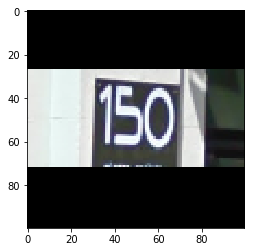

In [83]:
indices = np.arange(len(data['paths']))
np.random.shuffle(indices)
image_path = data['paths'][indices[0]]

image = imread(image_path, as_grey=False)

bigger_side = np.argmax(image.shape)
if image.shape[bigger_side] > 100:
    ratio = 100.0 / float(image.shape[bigger_side])
else:
    ratio = 1
    
print(image.shape)
image = skimage.transform.rescale(image, ratio, mode='wrap')
print(image.shape)
image = pad_image(image, (100, 100, 3))

plt.imshow(image)